In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

d:\Tianyu\software\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
d:\Tianyu\software\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [61]:
## savgol filter ##
def SG_fil(data,window,column_name,order=2):
    df = data.copy()
    for n in column_name:
        df[n] = savgol_filter(df.loc[:,n],window,order)
    return df

def lumin2cogload(lumin):
    # coeff_left = [2.451072052, -15.47037207, 2.49154129]
    # coeff_right = [2.489320955, -13.62467234, 2.540344354]
    coeff_left = [1.326173, -4.42176, 3.016348]
    coeff_right = [1.225595, -5.16006, 3.3087083]
    cogload_adjust_left = coeff_left[0]*np.exp(coeff_left[1]*lumin) + coeff_left[2]
    cogload_adjust_right = coeff_right[0]*np.exp(coeff_right[1]*lumin) + coeff_right[2]
    return cogload_adjust_left, cogload_adjust_right

def read_data(path):
    data_raw = []
    for home, dirs, files in os.walk(path):
        for filename in files:
            t = pd.read_csv(home+"/"+filename,index_col=0)
            t = t[40:-1].reset_index()

            t[["participant_id"]] = filename[1:3]
            t[["trail"]] = filename[4:6]
            if filename[4:6] == "01":
                t[["condition"]] = "Control"
            if (filename[4:6] == "02" or filename[4:6] == "03" or filename[4:6] == "04" or filename[4:6] == "05"):
                t[["condition"]] = "Anchoring"
            if (filename[4:6] == "06" or filename[4:6] == "07" or filename[4:6] == "08" or filename[4:6] == "09"):
                t[["condition"]] = "Asynchronized"

            t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
            t['RightPupilD'][t['RightPupilD']<0] = np.nan
            t[['LeftPupilD','RightPupilD']] = t[['LeftPupilD','RightPupilD']].interpolate(method='linear',axis=0,limit_direction ='both')
            t = SG_fil(t,5,['LeftPupilD','RightPupilD','Lumin'])

            (t[['cogload_adjust_left']], t[['cogload_adjust_right']]) = lumin2cogload(t[['Lumin']])
            t[['cogload_left']] = t[['LeftPupilD']].values - t[['cogload_adjust_left']].values
            t[['cogload_right']] = t[['RightPupilD']].values - t[['cogload_adjust_right']].values
            data_raw.append(t)
            
    return data_raw

## Calculate the time of each mission ##
def total_data_analysis(data_raw):
    data_analysis = pd.DataFrame()
    for i in range(len(data_raw)):      
        mission_time = np.zeros(2)
        time_all = len(data_raw[i])/90
        trail = data_raw[i][["trail"]][0:1].values.ravel()[0]
        condition = data_raw[i][["condition"]][0:1].values.ravel()[0]
        participant_id = data_raw[i][["participant_id"]][0:1].values.ravel()[0]
        mission_group = data_raw[i].groupby('CollisionTargetName')
        mission_white = mission_group.get_group('Object_White')
        mission_purple = mission_group.get_group('Object_Purple')
        
        time_white = len(mission_white)/90
        time_purple = len(mission_purple)/90
        if time_white < 1:
            white_fail = 1.0
        else:
            white_fail = 0.0
        if time_purple < 1:
            purple_fail = 1.0
        else:
            purple_fail = 0.0
        # cogload_left = (data_raw[i]["cogload_left"].mean())
        # cogload_right = (data_raw[i]["cogload_right"].mean())
        cogload_left = (data_raw[i]["LeftPupilD"].mean())
        cogload_right = (data_raw[i]["RightPupilD"].mean())
        average_cogload = (cogload_left + cogload_right)/2

        ## place down accuracy
        # white accuracy
        penalty_fails = 0

        white_start = np.array([97.56063,13.35121,-35.21387])
        white_end = np.array([97.90663,13.32971,-35.19188])
        # print(np.array(mission_white.iloc[-1][["Cube6X","Cube6Y","Cube6Z"]]))
        if white_fail == 0.0:
            white_place_down = np.array(mission_white.iloc[-1][["Cube6X","Cube6Y","Cube6Z"]])
            white_accuracy = np.sqrt(np.power(white_place_down[0] - white_end[0],2) + np.power(white_place_down[2] - white_end[2],2))
        else:
            if penalty_fails:
                time_white = 99.288889 # max white time
                time_all = time_all + time_white
                white_accuracy = np.sqrt(np.power(white_start[0] - white_end[0],2) + np.power(white_start[2] - white_end[2],2))
            else:
                time_white = np.nan
                time_all = np.nan
                white_accuracy = np.nan
        purple_start = np.array([98.09391,13.35521,-35.24587])
        purple_end = np.array([97.27963,13.61891,-34.86887])
        if purple_fail == 0.0:
            purple_place_down = np.array(mission_purple.iloc[-1][["Cube1X","Cube1Y","Cube1Z"]])
            purple_accuracy = np.sqrt(np.power(purple_place_down[0] - purple_end[0],2) + np.power(purple_place_down[2] - purple_end[2],2))
        else:
            if penalty_fails:
                time_purple = 93.466667
                time_all = time_all + time_purple
                purple_accuracy = np.sqrt(np.power(purple_start[0] - purple_end[0],2) + np.power(purple_start[2] - purple_end[2],2))
            else:
                time_purple = np.nan
                time_all = np.nan
                purple_accuracy = np.nan

        total_accuracy = white_accuracy + purple_accuracy

        data_analysis = data_analysis.append(pd.DataFrame([[trail,condition,participant_id,time_all,time_white,time_purple,average_cogload,
                                                            cogload_left,cogload_right,white_fail,purple_fail,total_accuracy,white_accuracy,purple_accuracy,
                                                            ]],
                                                columns=["trail","condition","participant_id","time_all","time_white","time_purple","average_cogload",
                                                        "cogload_left","cogload_right","white_fail","purple_fail","total_accuracy","white_accuracy","purple_accuracy",
                                                        ]),
                                                ignore_index=True)
    
    return data_analysis

In [18]:
path = '../data/test/'
data_raw = read_data(path)

<ipython-input-17-e9d64f75785c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
<ipython-input-17-e9d64f75785c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['RightPupilD'][t['RightPupilD']<0] = np.nan
<ipython-input-17-e9d64f75785c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
<ipython-input-17-e9d64f75785c>:34: SettingWithCopyWarning:

In [62]:
data_analysis = total_data_analysis(data_raw)

In [59]:
data_analysis_group = data_analysis.groupby('condition')
white_fail_control = data_analysis_group.get_group('Control')['white_fail'].sum()
white_fail_anchoring = data_analysis_group.get_group('Anchoring')['white_fail'].sum()
white_fail_asynchronized = data_analysis_group.get_group('Asynchronized')['white_fail'].sum()
purple_fail_control = data_analysis_group.get_group('Control')['purple_fail'].sum()
purple_fail_anchoring = data_analysis_group.get_group('Anchoring')['purple_fail'].sum()
purple_fail_asynchronized = data_analysis_group.get_group('Asynchronized')['purple_fail'].sum()

In [60]:
print(white_fail_control,white_fail_anchoring,white_fail_asynchronized,purple_fail_control,purple_fail_anchoring,purple_fail_asynchronized)

1.0 7.0 7.0 0.0 8.0 6.0


In [63]:
data_analysis

,trail,condition,participant_id,time_all,time_white,time_purple,average_cogload,cogload_left,cogload_right,white_fail,purple_fail,total_accuracy,white_accuracy,purple_accuracy
0,01,Control,01,52.666667,11.344444,6.866667,3.115973,3.168608,3.063339,0.0,0.0,0.046431,0.030385,0.016047
1,02,Anchoring,01,154.566667,34.000000,11.966667,3.190127,3.279304,3.100950,0.0,0.0,0.139977,0.104097,0.035880
2,03,Anchoring,01,NaN,25.066667,NaN,3.154991,3.209582,3.100399,0.0,1.0,NaN,0.055595,NaN
3,04,Anchoring,01,365.077778,28.477778,42.000000,3.256392,3.324063,3.188721,0.0,0.0,0.126702,0.069758,0.056944
4,05,Anchoring,01,314.455556,99.288889,64.577778,3.175793,3.213764,3.137822,0.0,0.0,0.065157,0.029320,0.035837
5,06,Asynchronized,01,119.966667,8.511111,33.388889,3.188920,3.287383,3.090457,0.0,0.0,0.082261,0.012375,0.069887
6,07,Asynchronized,01,197.955556,34.300000,37.611111,3.181994,3.247136,3.116852,0.0,0.0,0.079859,0.020387,0.059472
7,08,Asynchronized,01,225.711111,92.188889,26.144444,3.205563,3.232366,3.178761,0.0,0.0,0.194751,0.117594,0.077157
8,09,Asynchronized,01,644.222222,8.244444,93.466667,3.297887,3.361241,3.234532,0.0,0.0,0.517088,0.391917,0.125171
9,01,Control,02,NaN,NaN,40.477778,3.917995,3.637470,4.198520,1.0,0.0,NaN,NaN,0.021602


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=1.573e-01 stat=2.000e+00
Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=5.767e-01 stat=3.115e-01
Control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=1.742e-01 stat=1.846e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=6.506e-01 stat=2.051e-01
Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=9.387e-01 stat=5.917e-03
Control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=7.341e-01 stat=1.154e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.

IndexError: list index out of range

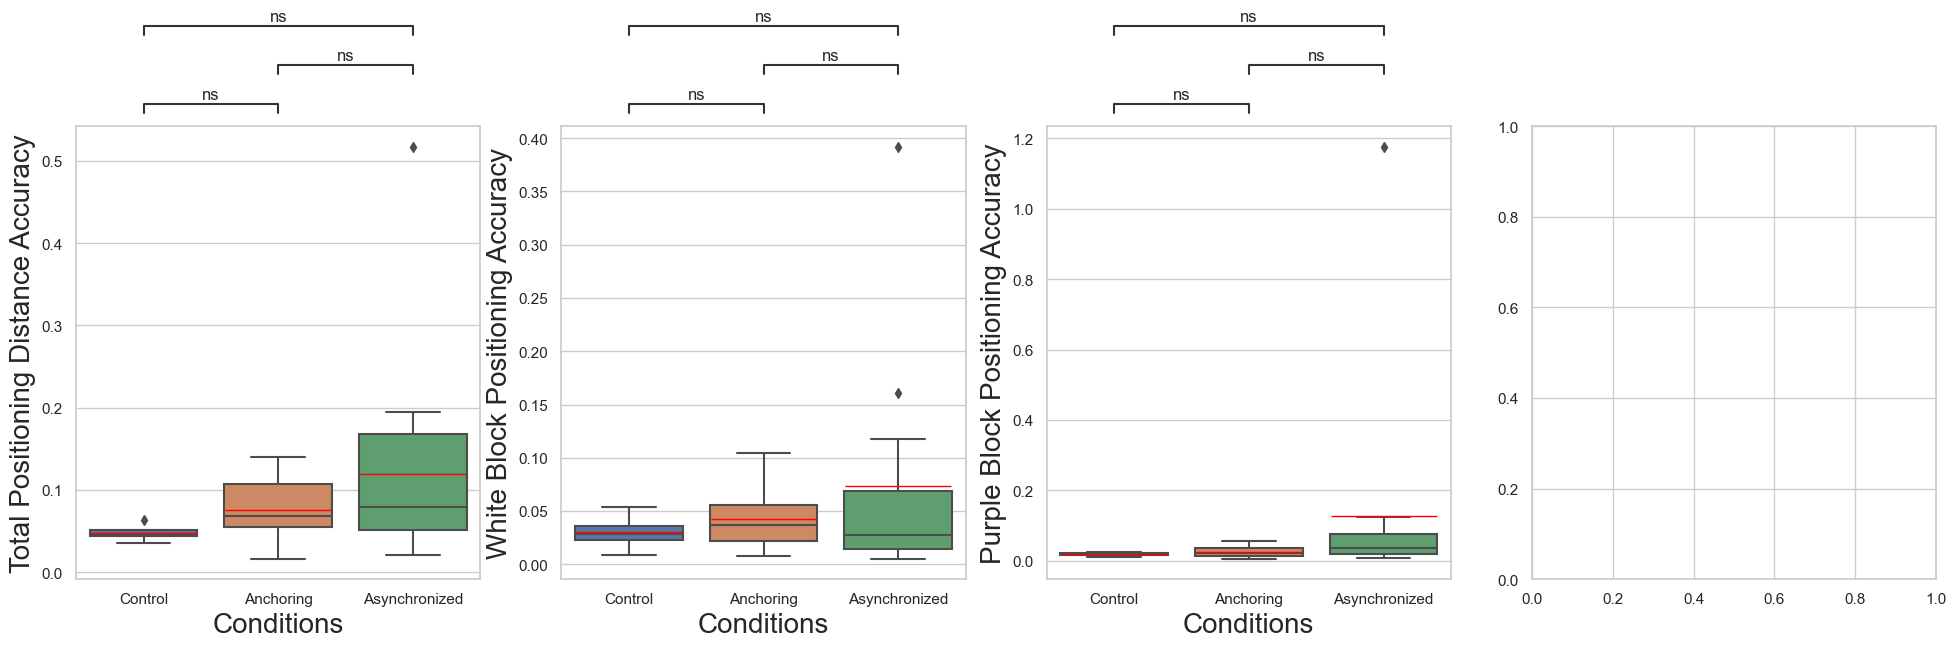

In [65]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
# y_list = ["time_all","time_white","time_purple","average_cogload"]; y_name = ['Total Time on Task','White Object Moving Time','Purple Object Moving Time','Average Cognitive Load']
y_list = ["total_accuracy","white_accuracy","purple_accuracy"]; y_name = ['Total Positioning Distance Accuracy','White Block Positioning Accuracy','Purple Block Positioning Accuracy']
# order = ["01","02","03","04","05","06","07","08","09"]
order = ["Control","Anchoring","Asynchronized"]
# method = 'Wilcoxon'
method = 'Kruskal'
data = data_analysis
box_pairs=[
         (order[0], order[1]),
         (order[0], order[2]),
         # (order[0], order[3]),
         (order[1], order[2]),
         # (order[1], order[3]),
         # (order[2], order[3]),
            ]
# box_pairs=[
#          (order[1], order[5]),
#          (order[2], order[6]),
#          (order[3], order[7]),
#          (order[4], order[8]),
#             ]
average_line_length = "76"


fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[0].set_xlabel('Conditions', fontsize = 20)
axes[0].set_ylabel(y_name[0], fontsize = 20)


y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[1].set_xlabel('Conditions', fontsize = 20)
axes[1].set_ylabel(y_name[1], fontsize = 20)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[2].set_xlabel('Conditions', fontsize = 20)
axes[2].set_ylabel(y_name[2], fontsize = 20)


y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
# axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[3].set_xlabel('Conditions', fontsize = 20)
axes[3].set_ylabel(y_name[3], fontsize = 20)




In [ ]:
### ----------------------------------------------- Questionnaire ---------------------------------------------------------------------------

In [181]:
nasa_tlx = pd.read_csv("../data/questionnaire/NASA TLX - Delay Control.csv")

In [182]:
nasa_tlx[["Mental Demand",
         "Physical Demand",
         "Temporal Demand",
         "Performance ",
         "Effort ",
         "Frustration ",
         ]] = nasa_tlx[["Mental Demand",
         "Physical Demand",
         "Temporal Demand",
         "Performance ",
         "Effort ",
         "Frustration ",
         ]].astype(float)
nasa_tlx['Condition'] = np.nan

In [183]:
for index, row in nasa_tlx.iterrows():
    if row['trail'] == 1:
        nasa_tlx.loc[index,['Condition']] = 'Control'
    if row['trail'] == 2 or row['trail'] == 3 or row['trail'] == 4 or row['trail'] == 5:
        nasa_tlx.loc[index,['Condition']] = 'Anchoring'
    if row['trail'] == 6 or row['trail'] == 7 or row['trail'] == 8 or row['trail'] == 9:
        nasa_tlx.loc[index,['Condition']] = 'Asynchronized'



In [184]:
nasa_tlx

,Timestamp,Participant serial number,trail,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,Condition
0,2022/11/09 11:07:40 AM EST,1,16,10.0,6.0,8.0,8.0,9.0,8.0,NaN
1,2022/11/09 11:20:12 AM EST,1,9,10.0,8.0,9.0,9.0,9.0,9.0,Asynchronized
2,2022/11/09 11:25:43 AM EST,1,2,6.0,6.0,2.0,3.0,5.0,3.0,Anchoring
3,2022/11/09 11:29:37 AM EST,1,6,4.0,4.0,2.0,3.0,3.0,3.0,Asynchronized
4,2022/11/09 11:34:48 AM EST,1,17,5.0,5.0,4.0,2.0,5.0,3.0,NaN
5,2022/11/09 11:42:37 AM EST,1,18,7.0,7.0,6.0,6.0,7.0,6.0,NaN
6,2022/11/09 11:46:27 AM EST,1,15,4.0,3.0,2.0,2.0,3.0,2.0,NaN
7,2022/11/09 11:53:20 AM EST,1,11,5.0,5.0,3.0,5.0,4.0,4.0,NaN
8,2022/11/09 11:56:03 AM EST,1,1,3.0,2.0,2.0,2.0,3.0,2.0,Control
9,2022/11/09 11:58:44 AM EST,1,10,3.0,3.0,2.0,2.0,3.0,2.0,NaN


In [187]:
nasa_tlx['total']= nasa_tlx.iloc[:,3]+nasa_tlx.iloc[:,4]+nasa_tlx.iloc[:,5]+nasa_tlx.iloc[:,6]\
                    +nasa_tlx.iloc[:,7]+nasa_tlx.iloc[:,8]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=1.129e-01 stat=2.513e+00
Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=7.169e-01 stat=1.315e-01
Control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=8.429e-02 stat=2.980e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=1.232e-01 stat=2.377e+00
Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=7.224e-01 stat=1.262e-01
Control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=7.449e-02 stat=3.181e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.

IndexError: list index out of range

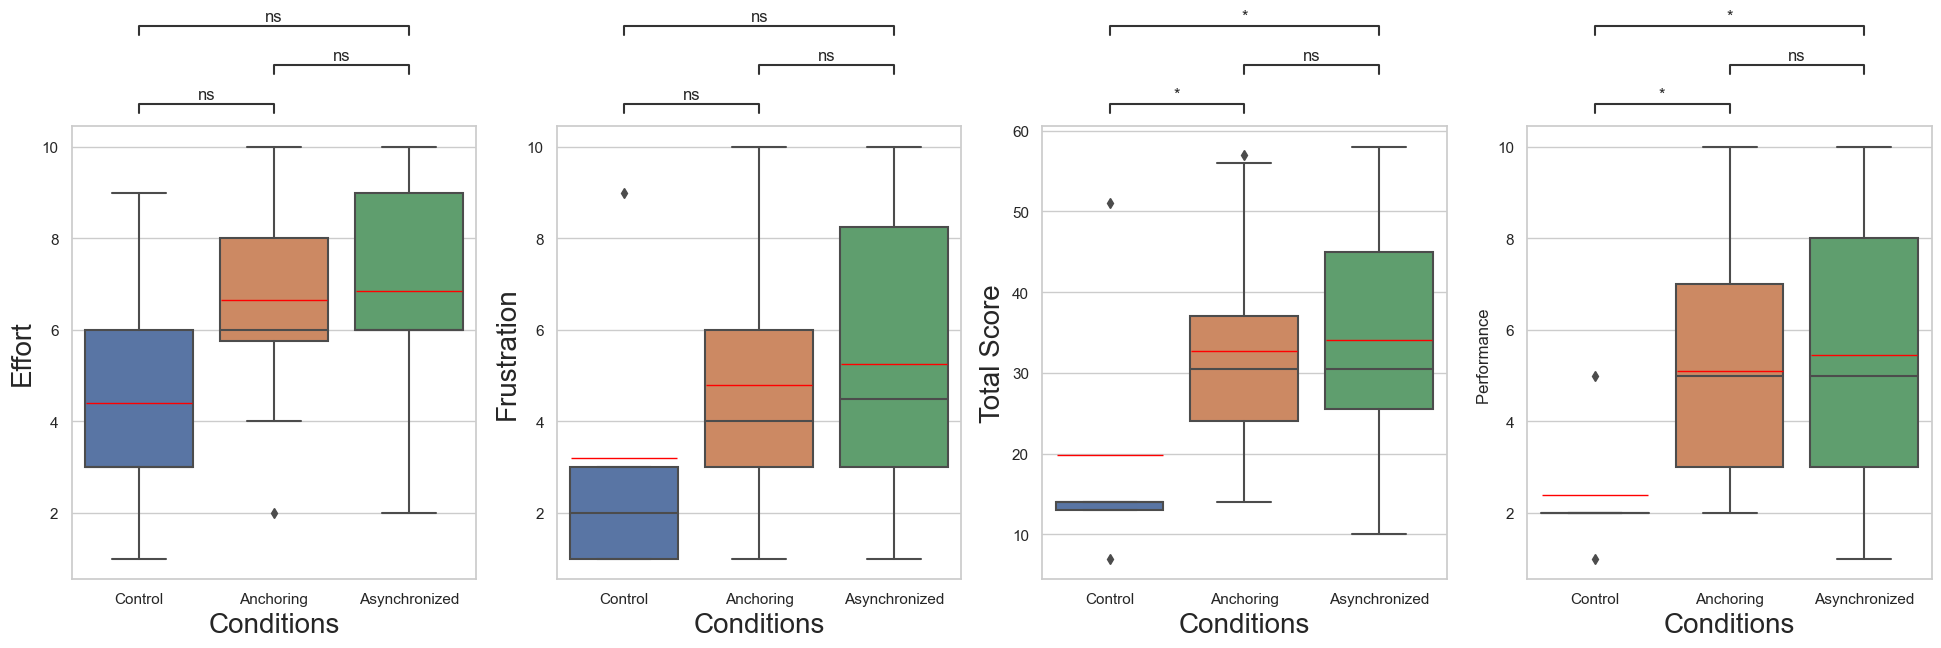

In [190]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'Condition'
# y_list = ["total"]  
# y_list = ["Mental Demand","Physical Demand","Temporal Demand","Performance "]; y_name = ["Mental Demand","Physical Demand","Temporal Demand","Performance"]
y_list = ["Effort ","Frustration ","total","Performance "]; y_name = ["Effort","Frustration","Total Score"]

# order = ["1","2","3","4","5","6","7","8","9"]
order = ["Control","Anchoring","Asynchronized"]
# method = 'Wilcoxon'
method = 'Kruskal'
data = nasa_tlx
box_pairs=[
         (order[0], order[1]),
         (order[0], order[2]),
         # (order[0], order[3]),
         (order[1], order[2]),
         # (order[1], order[3]),
         # (order[2], order[3]),
            ]
# box_pairs=[
#          (order[1], order[5]),
#          (order[2], order[6]),
#          (order[3], order[7]),
#          (order[4], order[8]),
#             ]
# average_line_length = "40"
average_line_length = "76"


fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[0].set_xlabel('Conditions', fontsize = 20)
axes[0].set_ylabel(y_name[0], fontsize = 20)

y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[1].set_xlabel('Conditions', fontsize = 20)
axes[1].set_ylabel(y_name[1], fontsize = 20)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[2].set_xlabel('Conditions', fontsize = 20)
axes[2].set_ylabel(y_name[2], fontsize = 20)

y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
# axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[3].set_xlabel('Conditions', fontsize = 20)
axes[3].set_ylabel(y_name[3], fontsize = 20)

In [ ]:
### -------------------------------------- Estimation Delay ---------------------------------------------

In [126]:
estimation_dalay_pd = pd.DataFrame()
estimation_dalay_pd['condition'] = [1,2,3,4,5,6,7,8,9]
estimation_dalay_pd['actual_visual_delay'] = [0,1.25,2.5,3.75,5,1.25,2.5,3.75,5]
estimation_dalay_pd['actual_haptic_delay'] = [0,0,0,0,0,0.25,0.25,0.25,0.25]
estimation_dalay_pd['p1_visual_delay'] = [0,0.5,3,3,4,1,3,2,5]
estimation_dalay_pd['p1_haptic_delay'] = [0,1.5,4,5,4,1.5,3,3,5]
estimation_dalay_pd['p2_visual_delay'] = [0.25,3,3,3,4.5,3,2.5,3,5]
estimation_dalay_pd['p2_haptic_delay'] = [0.25,1,2,4,4,2,2.5,1.5,5]
estimation_dalay_pd['p3_visual_delay'] = [1.0,2,3,4,5,3,3,5,4]
estimation_dalay_pd['p3_haptic_delay'] = [1.0,1,1,1,1,2,1,5,1]
estimation_dalay_pd['p4_visual_delay'] = [0.0,1,4,4,5,1,3,4,5]
estimation_dalay_pd['p4_haptic_delay'] = [0.0,1,1,2,1,0,0,1,1]
estimation_dalay_pd['p5_visual_delay'] = [0.5,1.5,4,5,5,2,4,3,5]
estimation_dalay_pd['p5_haptic_delay'] = [0.5,0.5,0.5,2,0.5,1,0.5,0,1.5]

In [131]:
for i in range(1,6):
    estimation_dalay_pd['p%s_visual_delay_difference' %i] = estimation_dalay_pd['p%s_visual_delay' %i] - estimation_dalay_pd['actual_visual_delay']
    estimation_dalay_pd['p%s_haptic_delay_difference' %i] = estimation_dalay_pd['p%s_haptic_delay' %i] - estimation_dalay_pd['actual_haptic_delay']

In [132]:
estimation_dalay_pd['visual_delay_difference_total'] = [0.0,0,0,0,0,0,0,0,0]
estimation_dalay_pd['haptic_delay_difference_total'] = [0.0,0,0,0,0,0,0,0,0]
for i in [13,15,17,19,21]:
    estimation_dalay_pd['visual_delay_difference_total'] = estimation_dalay_pd['visual_delay_difference_total'] + estimation_dalay_pd.iloc[:,i]
for i in [14,16,18,20,22]:
    estimation_dalay_pd['haptic_delay_difference_total'] = estimation_dalay_pd['haptic_delay_difference_total'] + estimation_dalay_pd.iloc[:,i]

In [99]:
estimation_dalay_pd = pd.read_excel('../data/estimation_dalay_pd.xlsx')

In [100]:
estimation_dalay_pd

,participant,trail,actual_visual_delay,actual_haptic_delay,visual_delay,haptic_delay,visual_delay_difference,haptic_delay_difference,condition
0,1,1,0.00,0.00,0.00,0.00,0.00,0.00,Control
1,1,2,1.25,0.00,0.50,1.50,-0.75,1.50,Anchoring
2,1,3,2.50,0.00,3.00,4.00,0.50,4.00,Anchoring
3,1,4,3.75,0.00,3.00,5.00,-0.75,5.00,Anchoring
4,1,5,5.00,0.00,4.00,4.00,-1.00,4.00,Anchoring
5,1,6,1.25,0.25,1.00,1.50,-0.25,1.25,Asynchronized
6,1,7,2.50,0.25,3.00,3.00,0.50,2.75,Asynchronized
7,1,8,3.75,0.25,2.00,3.00,-1.75,2.75,Asynchronized
8,1,9,5.00,0.25,5.00,5.00,0.00,4.75,Asynchronized
9,2,1,0.00,0.00,0.25,0.25,0.25,0.25,Control


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=7.319e-01 stat=1.174e-01
Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=8.701e-01 stat=2.675e-02
Control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=5.817e-01 stat=3.036e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=3.715e-03 stat=8.418e+00
Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=4.790e-01 stat=5.010e-01
Control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=5.993e-02 stat=3.539e+00


IndexError: list index out of range

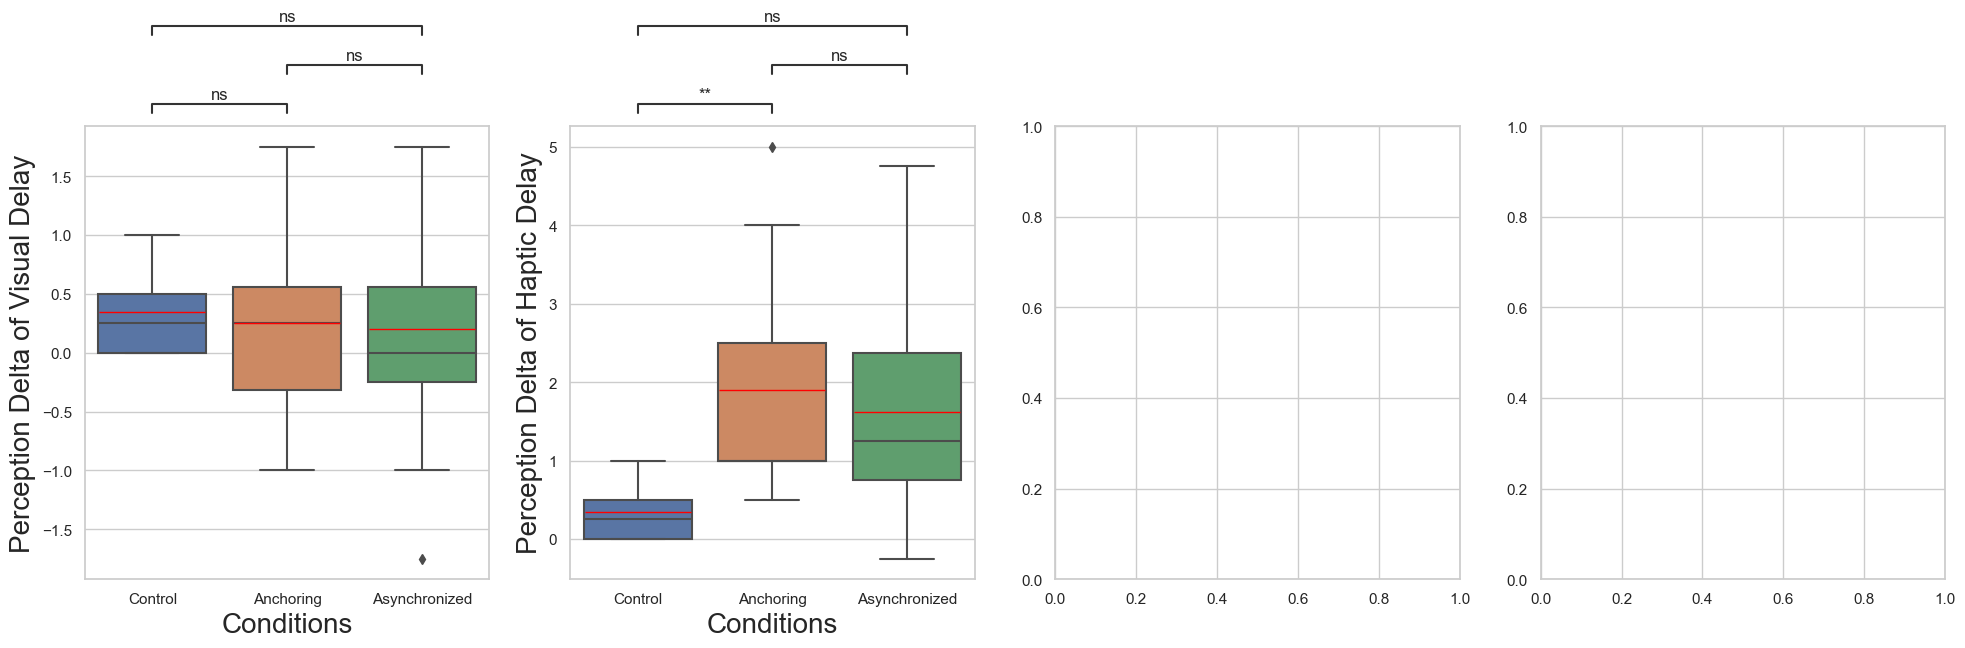

In [102]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
y_list = ["visual_delay_difference","haptic_delay_difference"]; y_name = ["Perception Delta of Visual Delay","Perception Delta of Haptic Delay"]
# order = [1,2,3,4,5,6,7,8,9]
order = ["Control","Anchoring","Asynchronized"]

# method = 'Wilcoxon'
method = 'Kruskal'
data = estimation_dalay_pd
box_pairs=[
         (order[0], order[1]),
         (order[0], order[2]),
         # (order[0], order[3]),
         (order[1], order[2]),
         # (order[1], order[3]),
         # (order[2], order[3]),
            ]

# box_pairs=[
#          (order[1], order[5]),
#          (order[2], order[6]),
#          (order[3], order[7]),
#          (order[4], order[8]),
#             ]
average_line_length = "76"


fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[0].set_xlabel("Conditions", fontsize = 20)
axes[0].set_ylabel(y_name[0], fontsize = 20)

y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[1].set_xlabel("Conditions", fontsize = 20)
axes[1].set_ylabel(y_name[1], fontsize = 20)


y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)

In [129]:
estimation_dalay_condition_group = estimation_dalay_pd.groupby('condition')
control_group = estimation_dalay_condition_group.get_group('Control')
anchoring_group = estimation_dalay_condition_group.get_group('Anchoring')
asynchronized_group = estimation_dalay_condition_group.get_group('Asynchronized')
mean_control = []
mean_anchoring = []
mean_asynchronized = []
max_control = []
max_anchoring = []
max_asynchronized = []
min_control = []
min_anchoring = []
min_asynchronized = []
for h,d in control_group.groupby('actual_visual_delay'):
    mean_control.append(d['visual_delay'].mean())
    max_control.append(d['visual_delay'].max())
    min_control.append(d['visual_delay'].min()) 
for h,d in anchoring_group.groupby('actual_visual_delay'):
    mean_anchoring.append(d['visual_delay'].mean())
    max_anchoring.append(d['visual_delay'].max())
    min_anchoring.append(d['visual_delay'].min())
for h,d in asynchronized_group.groupby('actual_visual_delay'):
    mean_asynchronized.append(d['visual_delay'].mean())
    max_asynchronized.append(d['visual_delay'].max())
    min_asynchronized.append(d['visual_delay'].min())

In [108]:
mean_asynchronized

[2.0, 3.1, 3.4, 4.8]

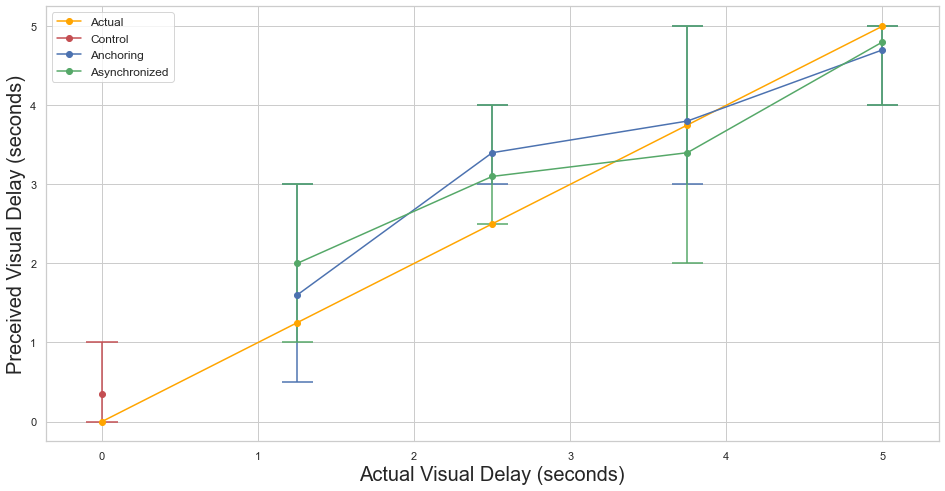

In [135]:
x = np.array([0,1.25,2.5,3.75,5])
y_actual = np.array([0,1.25,2.5,3.75,5])

fig = plt.figure(figsize=(16, 8))
plt.plot(x,y_actual, label='Actual',c='orange',marker='o')
plt.plot([0],mean_control, label='Control',c='r',marker="o")
plt.plot([1.25,2.5,3.75,5],mean_anchoring, label='Anchoring',c='b',marker="o")
plt.plot([1.25,2.5,3.75,5],mean_asynchronized, label='Asynchronized',c='g',marker="o")
plt.legend(loc="best",fontsize=12)

for i in range(len(x)):
    if i == 0:
        plt.hlines(y=max_control[0],xmin=x[i]-0.1,xmax=x[i]+0.1,colors='r')
        plt.hlines(y=min_control[0],xmin=x[i]-0.1,xmax=x[i]+0.1,colors='r')
        plt.vlines(x=x[i],ymin=min_control[0],ymax=max_control[0],colors='r')
    else:
        plt.hlines(y=max_anchoring[i-1],xmin=x[i]-0.1,xmax=x[i]+0.1,colors='b')
        plt.hlines(y=min_anchoring[i-1],xmin=x[i]-0.1,xmax=x[i]+0.1,colors='b')
        plt.vlines(x=x[i],ymin=min_anchoring[i-1],ymax=max_anchoring[i-1],colors='b')

        plt.hlines(y=max_asynchronized[i-1],xmin=x[i]-0.1,xmax=x[i]+0.1,colors='g')
        plt.hlines(y=min_asynchronized[i-1],xmin=x[i]-0.1,xmax=x[i]+0.1,colors='g')
        plt.vlines(x=x[i],ymin=min_asynchronized[i-1],ymax=max_asynchronized[i-1],colors='g')
        
plt.ylabel('Preceived Visual Delay (seconds)',fontsize = 20)
plt.xlabel('Actual Visual Delay (seconds)',fontsize = 20)

        

plt.show()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto_low_cogload_auto v.s. auto_low_cogload_self: Kruskal-Wallis paired samples, P_val=1.988e-01 stat=1.651e+00
self_low_cogload_auto v.s. self_low_cogload_self: Kruskal-Wallis paired samples, P_val=1.746e-01 stat=1.843e+00
self_low_cogload_auto v.s. auto_low_cogload_auto: Kruskal-Wallis paired samples, P_val=5.206e-01 stat=4.126e-01
self_low_cogload_self v.s. auto_low_cogload_self: Kruskal-Wallis paired samples, P_val=9.858e-02 stat=2.728e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto_low_cogload_auto v.s. auto_low_cogload_self: Kruskal-Wallis paired samples, P_val=8.210e-02 stat=3.023e+00
self_low_cogload_auto v.s. self_low_cogload_self: Kruskal-Wallis paired samples, P_val=1.939e-01 stat=1.688e+00


IndexError: list index out of range

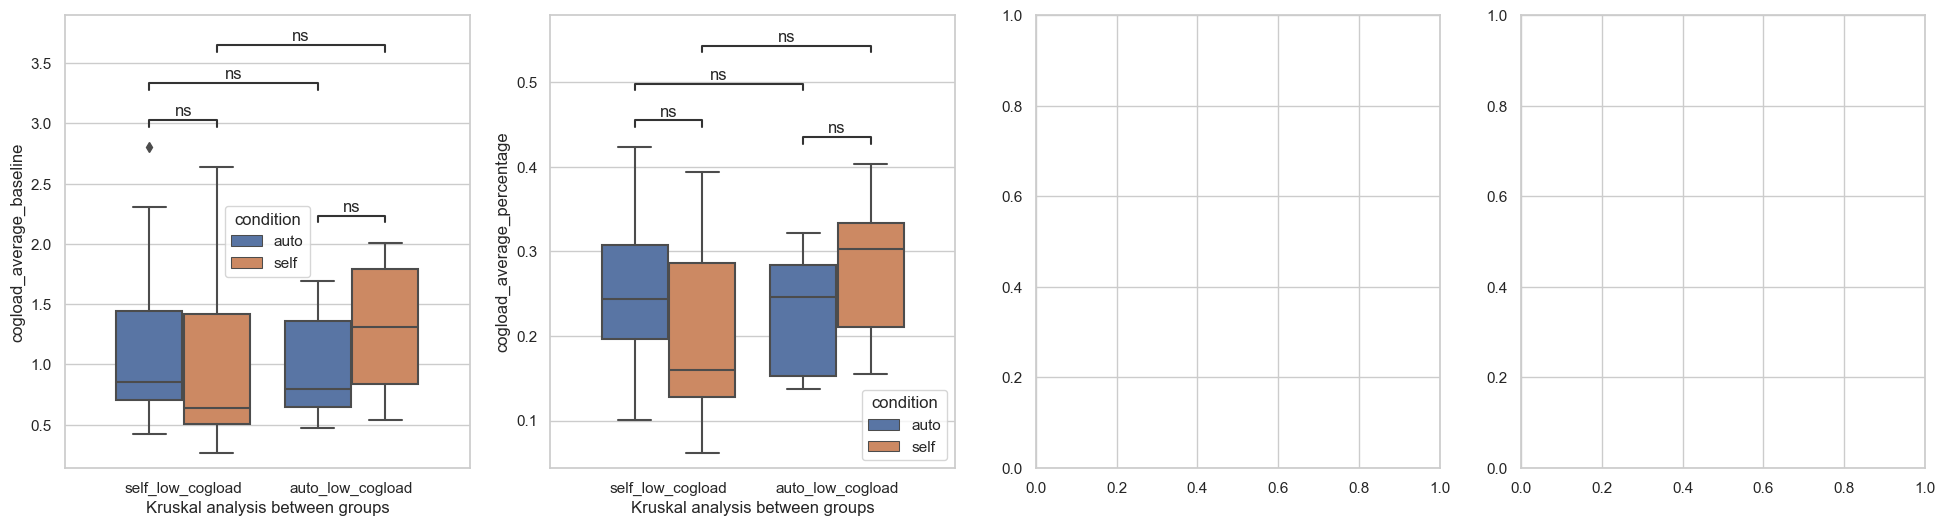

In [16]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'which_better'
y_list = ["task_finished_per_minute","damege_find_per_minute","score_per_minute","cogload_average_baseline"]  
# y_list = ["cogload_left_baseline","cogload_left_percentage","cogload_right_baseline","cogload_right_percentage"]  
# y_list = ["cogload_average_baseline","cogload_average_percentage"]
# order = ["cont","auto","self"]
order = ["auto_low_cogload","self_low_cogload"]
hue = "condition"
hue_order = ["auto","self"]

box_pairs = [
            ((order[0], hue_order[0]),(order[0], hue_order[1])),
            ((order[1], hue_order[0]),(order[1], hue_order[1])),
            ((order[0], hue_order[0]),(order[1], hue_order[0])),
            ((order[0], hue_order[1]),(order[1], hue_order[1])),
            ]

# method = 'Wilcoxon'
method = 'Kruskal'
data = data_two_pairwise
plot_line = 0

fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)

y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, hue=hue)
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[0].plot(plot_data)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,hue=hue,)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[1].plot(plot_data)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,hue=hue,)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[2].plot(plot_data)
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,hue=hue,)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[3].plot(plot_data)
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)

In [20]:
### sample from raw data 
rate = 20
data_image = copy.deepcopy(data_auto[1])
subset = data_image[::rate]
## 3D Stastic ###
if 1:
    df = subset
    fig = px.scatter_3d(df, x='CameraPosX', y='CameraPosY', z='CameraPosZ',
                color='Trend_Sum',color_continuous_scale=px.colors.sequential.Viridis,symbol='light_state',symbol_sequence=["cross","circle"],opacity=0.8,)
    fig.update_traces(marker_size = 3)
    fig.show()

In [ ]:
######################## Trajectory and entropy #################################

In [5]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        
        return sum(C)

    N = len(U)
    if _phi(m) == 0:
        return 0.2
    else:
        return -np.log(_phi(m + 1) / _phi(m))
